# Finetune PaliGemma




**This notebook shows how to finetune PaliGemma on a vision-language task.**

To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

This notebook uses the model reference implementation from [big_vision](https://github.com/google-research/big_vision).
and shows how to:

 * Install deps, download model checkpoint and training data.
 * Load the model onto GPU devices.
 * Prepare the input to the model for training and inference.
 * Finetune the model and inspect output in validation split.

## Setup

In [1]:
!pip install transformers
!pip install datasets
!pip install pandas
!pip install pillow
!pip install requests


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 2

In [7]:
# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Configure your API key to access Kaggle

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

1. To generate a Kaggle API key, go to the **Account** tab of your Kaggle user profile and select **Create New Token**. This will trigger the download of a `kaggle.json` file containing your API credentials.
1. In Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

To be able to download, you will also need to acknowledge the Terms and Conditions of the PaliGemma on:

* https://www.kaggle.com/models/google/paligemma/



In [10]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

## Notebook

In [11]:
#This prevents JAX lib from over occupying the GPU beforehand and only occupy as much as needed.
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="50" #this implies that initially JAX will occupy 50% of GPU
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

In [12]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece


from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs inorder to avoid clash with JAX
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


In [13]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")


100%|██████████| 5.45G/5.45G [02:01<00:00, 48.0MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


In [14]:
# @title Construct model and load params into RAM.

# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

In [15]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [16]:
# @title Define preprocess functions to create inputs to the model.

from PIL import Image
from io import BytesIO
import requests

def download_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [17]:

from datasets import load_dataset

# `name` can be one of: IIW-400, DCI_Test, DOCCI_Test, CM_3600, LocNar_Eval
# refer: https://github.com/google/imageinwords/tree/main/datasets
dataset = load_dataset('google/imageinwords', token=None, name="IIW-400", trust_remote_code=True)["test"]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split: 0 examples [00:00, ? examples/s]

Remove irrelevant coloumns and split into train, validation and test datsets

In [18]:
dataset_int = dataset.remove_columns(['IIW-P5B', 'iiw-human-sxs-gpt4v', 'iiw-human-sxs-iiw-p5b'])


In [19]:
train_validtest = dataset_int.train_test_split(test_size=0.3, seed=42)
train_dataset = train_validtest['train']
val_test = train_validtest['test'].train_test_split(test_size=0.33, seed=42)
val_dataset = val_test['train']
test_dataset = val_test['test']

In [20]:
# @title Function to iterate over train and validation examples.
import pandas as pd
SEQLEN = 128


def convert_to_tf_dataset(dataset):
  df = dataset.to_pandas()

  tf_dataset = tf.data.Dataset.from_tensor_slices(dict(df))

  tf_dataset = tf_dataset.map(lambda x: {
    'image/key': tf.convert_to_tensor(x['image/key'], dtype=tf.string),
    'image/url': tf.convert_to_tensor(x['image/url'], dtype=tf.string),
    'IIW': tf.convert_to_tensor(x['IIW'], dtype=tf.string)})

  return tf_dataset


def train_data_iterator(train_dataset):
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  X = convert_to_tf_dataset(train_dataset)
  dataset_tmp = X.shuffle(1_000).repeat()

  for example in dataset_tmp.as_numpy_iterator():

    img = example["image/url"].decode()
    img_url = requests.get(img).content
    image = Image.open(io.BytesIO(img_url))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["IIW"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }

def validation_data_iterator(val_dataset):
  """Single iterator over validation examples."""
  dataset_tmp = convert_to_tf_dataset(val_dataset)

  for example in dataset_tmp.as_numpy_iterator():
    # print(example["image/url"])
    # print(example["IIW"])
    # break
    img = example["image/url"].decode()
    img_url = requests.get(img).content
    image = Image.open(io.BytesIO(img_url))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["IIW"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }
def test_data_iterator(test_dataset):
  """Single iterator over validation examples."""
  dataset_tmp = convert_to_tf_dataset(test_dataset)

  for example in dataset_tmp.as_numpy_iterator():
    # print(example["image/url"])
    # print(example["IIW"])
    # break
    img = example["image/url"].decode()
    img_url = requests.get(img).content
    image = Image.open(io.BytesIO(img_url))
    image = preprocess_image(image)

    prefix = "caption en"  # Could also be a different prefix per example.
    suffix = example["IIW"].decode().lower()
    tokens, mask_ar, mask_loss, mask_input = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
        "mask_input": np.asarray(mask_input)
    }


In [21]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.

@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient


  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

def validation_fn(params, batch):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=False)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss = loss_fn(params)
  return loss


def compute_full_validation_loss(params, val_data_set, validation_batch_size, data_sharding):
    total_loss = 0.0
    total_examples = 0
    batch_count = 0
    val_data_it = validation_data_iterator(val_data_set)

    while True:
        try:
            val_examples = [next(val_data_it) for _ in range(validation_batch_size)]

            # Convert list of validation examples into a dict of np.arrays and load onto devices.
            val_batch = jax.tree_util.tree_map(lambda *x: np.stack(x), *val_examples)
            val_batch = big_vision.utils.reshard(val_batch, data_sharding)

            # Calculate validation loss on the device
            val_loss = validation_fn(params, val_batch)

            # Retrieve the validation loss from the device to the host
            val_loss = jax.device_get(val_loss)

            # Accumulate the total loss and the number of examples
            batch_size = len(val_examples)
            total_loss += val_loss * batch_size
            total_examples += batch_size
            batch_count += 1
        except StopIteration:
            break

    # Compute the mean validation loss
    mean_val_loss = total_loss / total_examples
    return mean_val_loss

def compute_full_test_inference(params, test_data_set, test_batch_size, data_sharding,seqlen=SEQLEN,sampler="greedy"):
    total_loss = 0.0
    total_examples = 0
    test_data_it = test_data_iterator(test_data_set)

    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(test_batch_size):
                examples.append(next(test_data_it))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                break

        # Not enough examples to complete a batch. Pad by repeating the last example.
        while len(examples) % test_batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of test examples into a dict of np.arrays and load onto devices.
        test_batch = jax.tree_util.tree_map(lambda *x: np.stack(x), *examples)
        test_batch = big_vision.utils.reshard(test_batch, data_sharding)

        # Make model predictions
        tokens = decode({"params": params}, batch=test_batch,
                        max_decode_len=seqlen, sampler=sampler)

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, test_batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        responses = [postprocess_tokens(t) for t in tokens]

        # Calculate test loss on the device
        # Here, you would adjust the loss calculation based on your specific task
        # For example, if you are evaluating classification accuracy, you would compute it here.
        test_loss = validation_fn(params, test_batch)  # Adjust to your loss function

        # Retrieve the test loss from the device to the host
        test_loss = jax.device_get(test_loss)

        # Accumulate the total loss and the number of examples
        batch_size = len([ex for ex in examples if ex["_mask"]])
        total_loss += test_loss * batch_size
        total_examples += batch_size

    # Compute the mean test loss
    mean_test_loss = total_loss / total_examples
    return mean_test_loss,zip(examples, responses)








In [22]:
# @title Run training loop.
#
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
TRAIN_EXAMPLES = 1000
LEARNING_RATE = 0.03
VAL_EXAMPLES = len(val_dataset)
TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8
validation_steps = VAL_EXAMPLES // BATCH_SIZE
train_data_it = train_data_iterator(train_dataset)
sched_fn = big_vision.utils.create_learning_rate_schedule(total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,decay_type="cosine", warmup_percent=0.10)
Train_losses=[]
Valid_losses=[]
steps = []

for step in range(1, TRAIN_STEPS+1):
  print(step)
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  # print("Start")
  params, loss = update_fn(params, batch, learning_rate)
  # print("Back")
  loss = jax.device_get(loss)

  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")
  Train_losses.append(loss)
  steps.append(step)

  if step == 1 or (step % EVAL_STEPS) == 0:
    print(f"Model validaton at step {step}")
    # mean_val_loss = compute_full_validation_loss(params, val_data_it, validation_steps, VAL_BATCH_SIZE, data_sharding)
    mean_val_loss = compute_full_validation_loss(params, val_dataset, VAL_BATCH_SIZE, data_sharding)
    Valid_losses.append(mean_val_loss)
    print(f"Validation Step {step}, Mean Loss: {mean_val_loss}")



1
step:  1/125   lr: 0.00231   loss: 3.4312
Model validaton at step 1
Validation Step 1, Mean Loss: 3.2114773631095885
2
step:  2/125   lr: 0.00462   loss: 3.2871
3
step:  3/125   lr: 0.00692   loss: 2.9367
4
step:  4/125   lr: 0.00923   loss: 2.8216
5
step:  5/125   lr: 0.01154   loss: 2.8974
6
step:  6/125   lr: 0.01385   loss: 2.9517
7
step:  7/125   lr: 0.01615   loss: 2.9316
8
step:  8/125   lr: 0.01846   loss: 2.8267
9
step:  9/125   lr: 0.02077   loss: 2.6274
10
step: 10/125   lr: 0.02308   loss: 2.7076
11
step: 11/125   lr: 0.02538   loss: 2.8830
12
step: 12/125   lr: 0.02769   loss: 2.8788
13
step: 13/125   lr: 0.03000   loss: 2.7142
14
step: 14/125   lr: 0.02999   loss: 2.7674
15
step: 15/125   lr: 0.02998   loss: 2.8262
Model validaton at step 15
Validation Step 15, Mean Loss: 2.6377625942230223
16
step: 16/125   lr: 0.02995   loss: 2.5801
17
step: 17/125   lr: 0.02991   loss: 2.4693
18
step: 18/125   lr: 0.02986   loss: 2.4974
19
step: 19/125   lr: 0.02979   loss: 2.7961
20

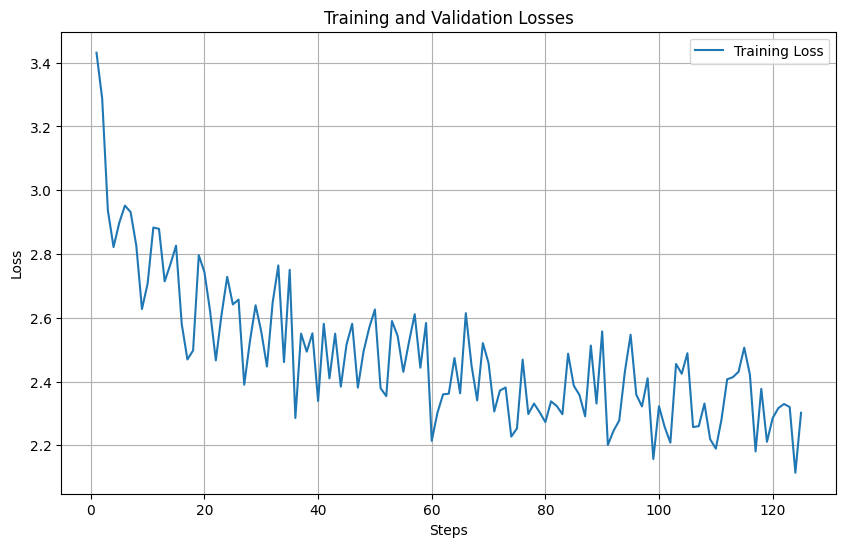

In [24]:
import matplotlib.pyplot as plt

# Plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(steps, Train_losses, label='Training Loss')
# plt.plot(steps, Valid_losses, label='Validation Loss')
plt.title('Training Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

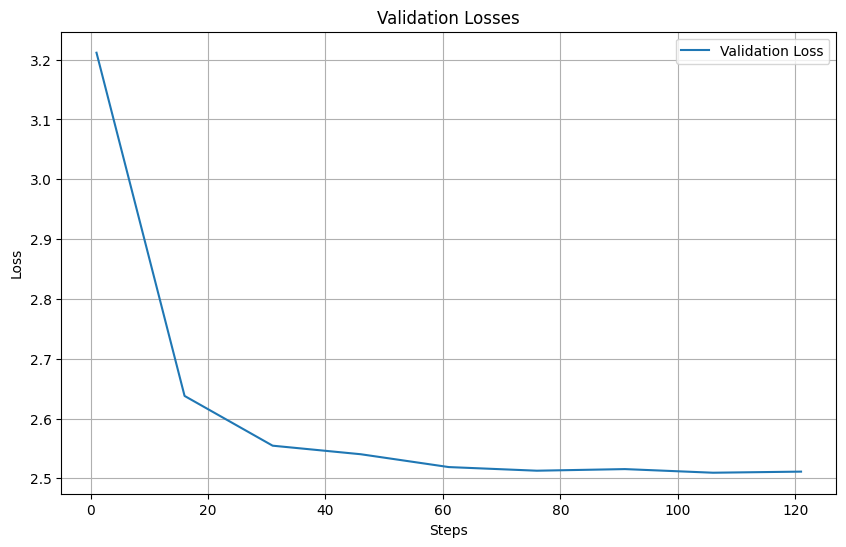

In [29]:
# Plotting training and validation losses
start = 1
step = EVAL_STEPS
limit = TRAIN_STEPS

# Generate the list
val_steps = list(range(start, limit + 1, step))
plt.figure(figsize=(10, 6))
plt.plot(val_steps,Valid_losses, label='Validation Loss')

plt.title('Validation Losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
TEST_BATCH_SIZE=4
mean_test_loss,eg_responses = compute_full_test_inference(params, test_dataset, TEST_BATCH_SIZE, data_sharding)

print(f"Mean Test Loss: {mean_test_loss:.4f}")

In [ ]:
for item in eg_responses:
  example = item[0]
  response = item[1]
  # print(f"Image: {example['image']}")
  print(f"Caption:{example['text']}")
  print(f"Response: {response}")
  # print()

# Save the final checkpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def npsave(pytree, path):
    names_and_vals, _ = big_vision.utils.tree_flatten_with_names(pytree)
    full_path = '/content/drive/MyDrive/Colab Notebooks' + path  # Adjust the path as needed
    with open(full_path, "wb") as f:
        np.savez(f, **{k: v for k, v in names_and_vals})

# Usage example:
npsave(params, 'my-custom-paligemma-ckpt.npz')